In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.set_figure_params(dpi=100)
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Ensures TrueType fonts — editable in Illustrator
mpl.rcParams['ps.fonttype'] = 42   # For EPS compatibility, too

In [4]:
out_dir = "output"
os.makedirs(out_dir, exist_ok=True)

In [5]:
custom_cmap_ck = {
    "podocyte": "#800080",
    "PEC": "#008080",
    "MC": "#FFD700",
    "Fibrotic MC": "#000000",
    "EC": "#00BFFF",
    "VSM/P": "#20B2AA",
    "PapE": "#006400",
    "PT": "#228B22",
    "ATL": "#32CD32",
    "CNT": "#90EE90",
    "DCT": "#98FB98",
    "DTL": "#00FA9A",
    "TAL": "#3CB371",
    "FIB": "#4682B4",
    "IC": "#1E90FF",
    "NEU": "#FFD700",
    "PC": "#DAA520",
    "T": "#FF0000",
    "NKC/T": "#DC143C",
    "B": "#4169E1",
    "PL": "#6495ED",
    "N": "#800000",
    "MAC": "#A52A2A",
    "MDC": "#8B4513",
    "Mono": "#D2691E",
    "MAST": "#FF1493",
    "cDC": "#FF69B4",
    "pDC": "#DB7093",
    "cycMNP": "#FFB6C1",
    "cycNKC/T": "#FFC0CB"
}

custom_cmap = custom_cmap_ck
print(custom_cmap)


{'podocyte': '#800080', 'PEC': '#008080', 'MC': '#FFD700', 'Fibrotic MC': '#000000', 'EC': '#00BFFF', 'VSM/P': '#20B2AA', 'PapE': '#006400', 'PT': '#228B22', 'ATL': '#32CD32', 'CNT': '#90EE90', 'DCT': '#98FB98', 'DTL': '#00FA9A', 'TAL': '#3CB371', 'FIB': '#4682B4', 'IC': '#1E90FF', 'NEU': '#FFD700', 'PC': '#DAA520', 'T': '#FF0000', 'NKC/T': '#DC143C', 'B': '#4169E1', 'PL': '#6495ED', 'N': '#800000', 'MAC': '#A52A2A', 'MDC': '#8B4513', 'Mono': '#D2691E', 'MAST': '#FF1493', 'cDC': '#FF69B4', 'pDC': '#DB7093', 'cycMNP': '#FFB6C1', 'cycNKC/T': '#FFC0CB'}


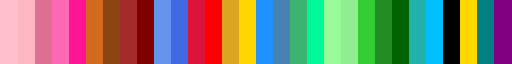

In [6]:
cmap = plt.cm.colors.ListedColormap(list(custom_cmap.values())[::-1])
# The cmap is converting the dictionary of colours to a list because dictionary is not ordered. 
#When I want to invert the valeus within the stacked barplot to have the order of rows match exactly the order in which the cell tpyes appaer in the bar plot, I have to invert the rows of the table.
#Howevre when I did that the cmap colours where losing teh order. So it was needed to also invert the cmap list!
cmap

In [7]:
cell_types_order = ['podocyte', 'PEC', 'MC', 'Fibrotic MC','PapE','VSM/P','EC' ,
                        'PT', 'ATL', 'CNT', 'DCT', 'DTL', 'TAL',
                        'FIB','IC', 'NEU','PC',
                        'T', 'NKC/T','B', 'PL',
                       'N', 'MAC', 'MDC', 'Mono', 'MAST',
                       'cDC', 'pDC', 'cycMNP', 'cycNKC/T']
disease_order = ["Cntrl", "ANCA"]

def Calculate_CellType_counts_perc(adata,cell_types_order,disease_order):

    counts_table = pd.crosstab(adata.obs["celltype_l1"], adata.obs["Disease"])
    
    # Compute the sum of cells for each disease condition
    disease_totals = counts_table.sum(axis=0)
    
    # Divide each cell count by the total count of cells in the respective disease condition
    perc_table = counts_table.divide(disease_totals, axis=1) * 100
    
    #The follwoin will decide the order of the cell types within the stacked barplot and seq of conditions
    cell_types_order = cell_types_order
    disease_order = disease_order
    
    
    counts_table_ordered = counts_table.reindex(columns=disease_order, index=cell_types_order)
    perc_table_ordered = perc_table.reindex(columns=disease_order, index=cell_types_order)
    
    return counts_table_ordered, perc_table_ordered

In [8]:
def plot_heatmap_counts(table):
    plt.figure(figsize=(7,10))
    ax=sns.heatmap(table, annot=True, fmt=".0f", cmap="bone_r", linewidths=0.05, linecolor="black", cbar=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title('cell counts')

In [9]:
def plot_heatmap_perc(table):
    plt.figure(figsize=(7,10))
    ax=sns.heatmap(table, annot=True, fmt=".2f", cmap="bone_r", linewidths=0.05, linecolor="black", cbar=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Perc. of diff. cell types")

In [10]:
def plot_stacked_bar(table, table_name, color_dict=None,figsize=(2, 3)):
    
    table = table[::-1]  # Reverse the rows to ensure POD is at the top of the stacked barplot
    
    sns.set(style="ticks")

    # Ensure the colors are mapped according to the order in the table's index (rows)
    if color_dict:
        color_list = [color_dict.get(cell_type, "#333333") for cell_type in table.index]# get the color from dictionary or set gray
    else:
        color_list = None  # fallback to default colors

    ax = table.T.plot(kind="bar", stacked=True, figsize=figsize, color=color_list)

    # Reversing handles and labels so legend matches bar order
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], ncol=3, bbox_to_anchor=(1, 1), frameon=False)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("")
    ax.set_title(table_name)

    # Creating file name
    file_name = re.sub(r'[^a-zA-Z0-9]+', '_', table_name.lower())
    file_name = "Composition_" + file_name

    plt.savefig(os.path.join(out_dir, file_name) + '.pdf', bbox_inches='tight', transparent=True)
    plt.savefig(os.path.join(out_dir, file_name) + '.png', bbox_inches='tight')
    plt.show()


### Cell Types Composition : NucSeq

In [11]:
adata = sc.read_h5ad('./output/data_objects/NucSeq_integrated_v1_annotated_oldTransfer.h5ad')

In [12]:
rename_dict = {
    "Transformed mesangial": "Fibrotic MC",
    "mesangial cell": "MC",
}
adata.obs["celltype_l1"] = adata.obs["celltype_l1"].replace(rename_dict)

/tmp/ipykernel_1414/278023497.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["celltype_l1"] = adata.obs["celltype_l1"].replace(rename_dict)


In [13]:
counts_table, perc_table = Calculate_CellType_counts_perc(adata,cell_types_order,disease_order)

In [14]:
#plot_heatmap_counts(counts_table)

In [15]:
#plot_heatmap_perc(perc_table)

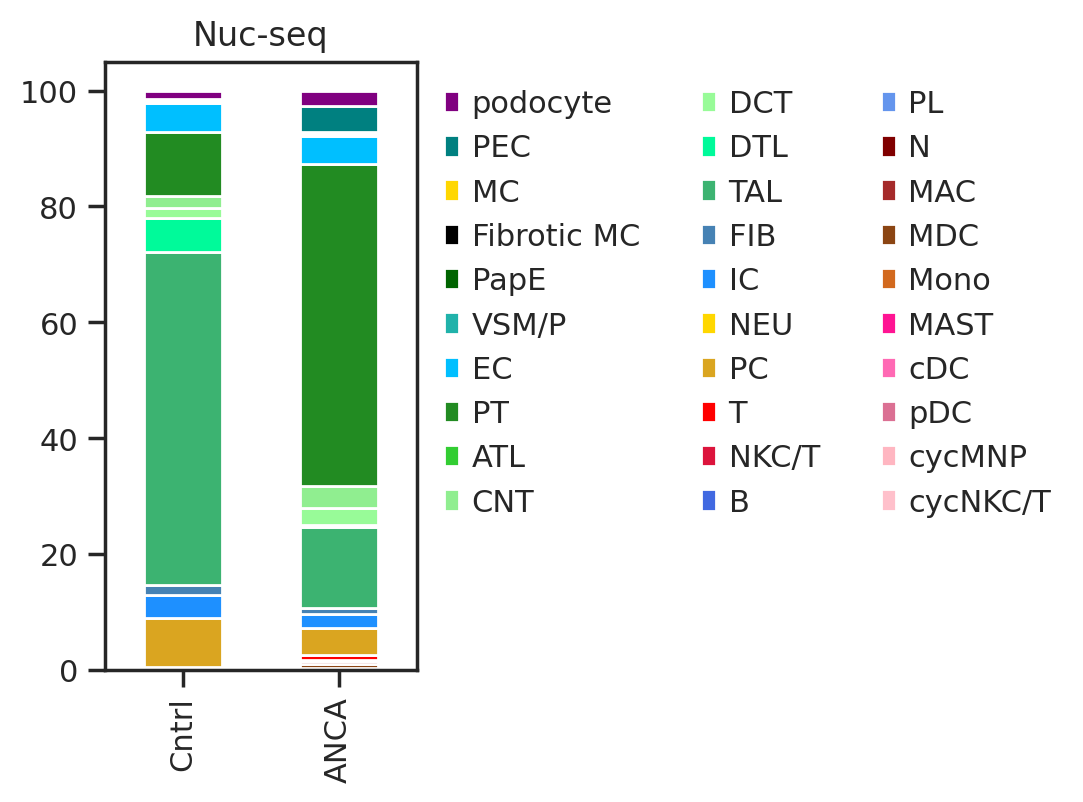

In [16]:
plot_stacked_bar(table=perc_table,table_name='Nuc-seq',color_dict=custom_cmap_ck,figsize=(2, 4))

In [17]:
### Testing if all cell types are covered
NucSeq_cellTypes = list(adata.obs.celltype_l1.unique())
diff = set(cell_types_order) - set(NucSeq_cellTypes)
diff

diff2 =  set(NucSeq_cellTypes)-set(cell_types_order) 
diff2

set()

### Cell Types Composition : Xenium

In [18]:
#Xen_adata = sc.read_h5ad("/data/projects/robin/segmentation/xenium_outs/adata_complete_reduced_withTransformedMC.h5ad")
Xen_adata = sc.read_h5ad('/data/projects/zeba/MY_PROJECTS/240130_Xenium_ANCA_SLE_GBM/xenium-cgn/notebooks_zs/02_PeriglomDefinition_Sample26updated/output_dataobjects/adata_complete_reduced_withTransformedMC_X26updated.h5ad')

In [19]:
rename_dict = {
    "Transformed mesangial": "Fibrotic MC",
    "mesangial cell": "MC",
}
Xen_adata.obs["celltype_l1"] = Xen_adata.obs["celltype_l1"].replace(rename_dict)

/tmp/ipykernel_1414/1060526337.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  Xen_adata.obs["celltype_l1"] = Xen_adata.obs["celltype_l1"].replace(rename_dict)


In [20]:
Xen_counts_table, Xen_perc_table = Calculate_CellType_counts_perc(Xen_adata,cell_types_order,disease_order)

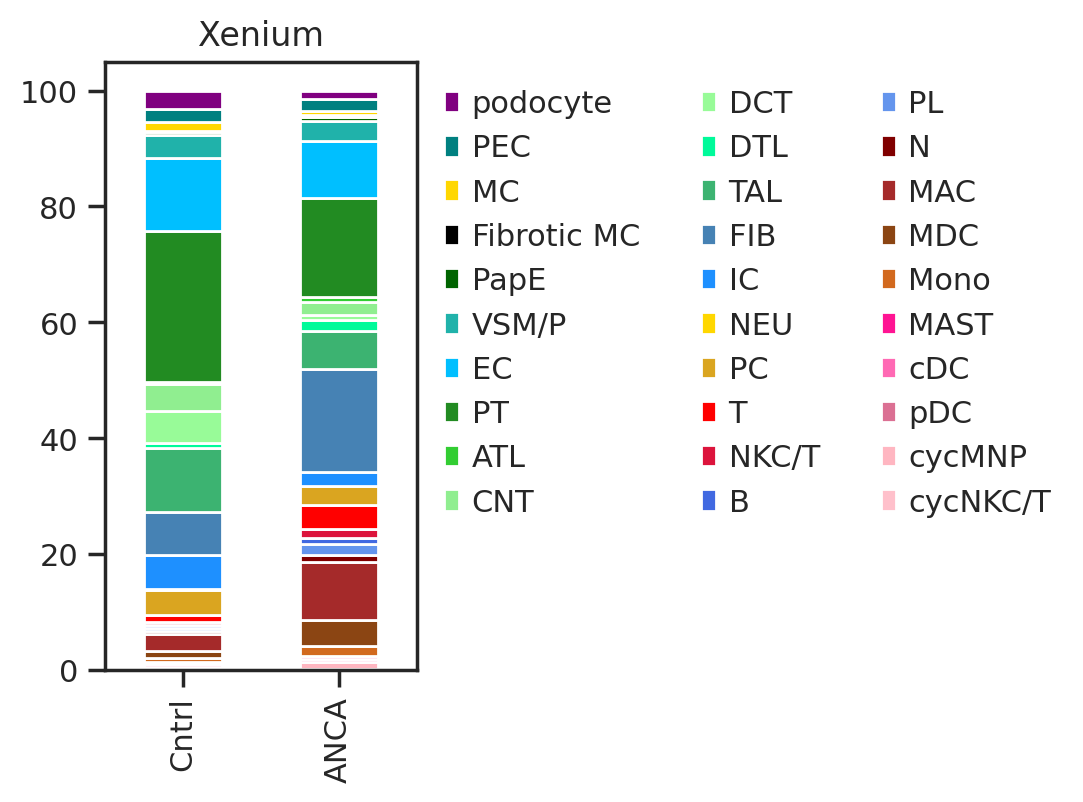

In [21]:
plot_stacked_bar(table=Xen_perc_table,table_name='Xenium',color_dict=custom_cmap_ck,figsize=(2, 4))

### Comparing Nuc-Seq and Xenium in only ANCA conditions

In [22]:
perc_table_ANCA = perc_table.drop(columns = "Cntrl")
Xen_perc_table_ANCA= Xen_perc_table.drop(columns="Cntrl")

perc_table_ANCA.rename(columns = {
    "ANCA":"ANCA_Nuc"}, inplace=True)
Xen_perc_table_ANCA.rename(columns = {
    "ANCA":"ANCA_Xen"}, inplace=True)


Xen_Nuc_ANCA = pd.merge( perc_table_ANCA, Xen_perc_table_ANCA, left_index=True, right_index=True)

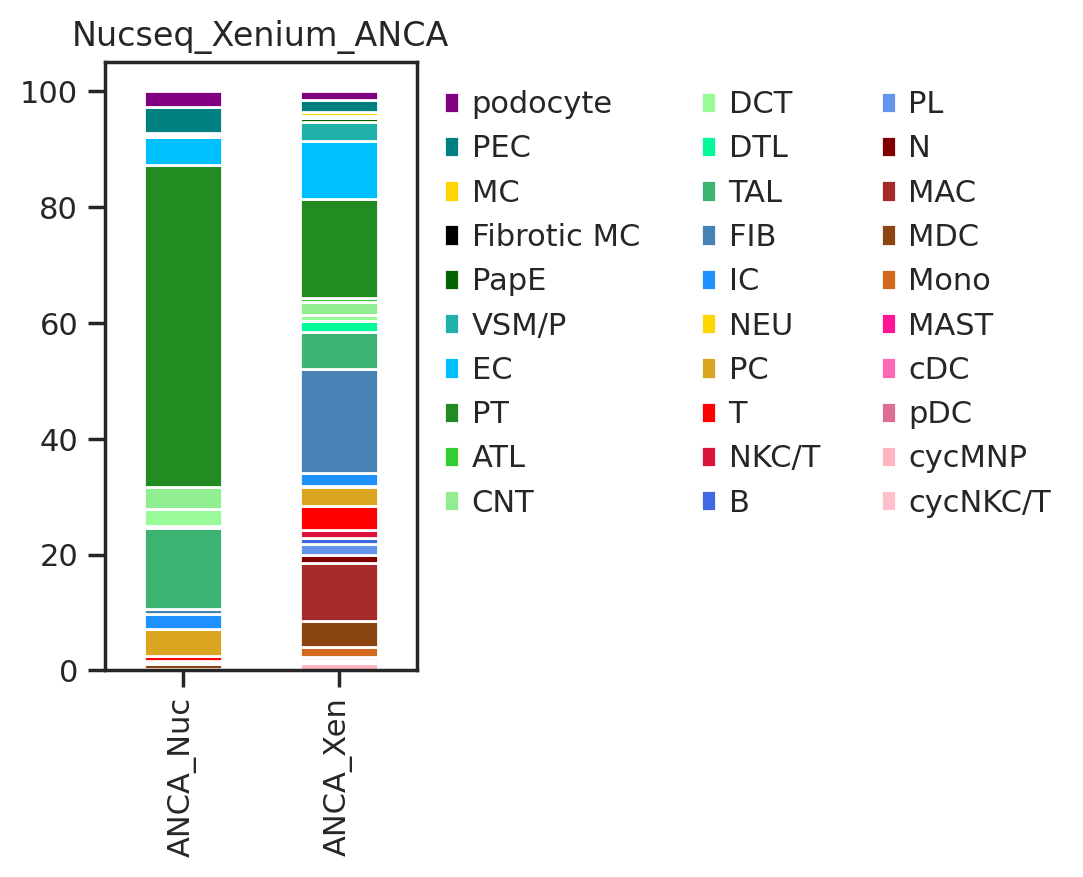

In [23]:
plot_stacked_bar(table=Xen_Nuc_ANCA,table_name='Nucseq_Xenium_ANCA',color_dict=custom_cmap_ck,figsize=(2, 4))

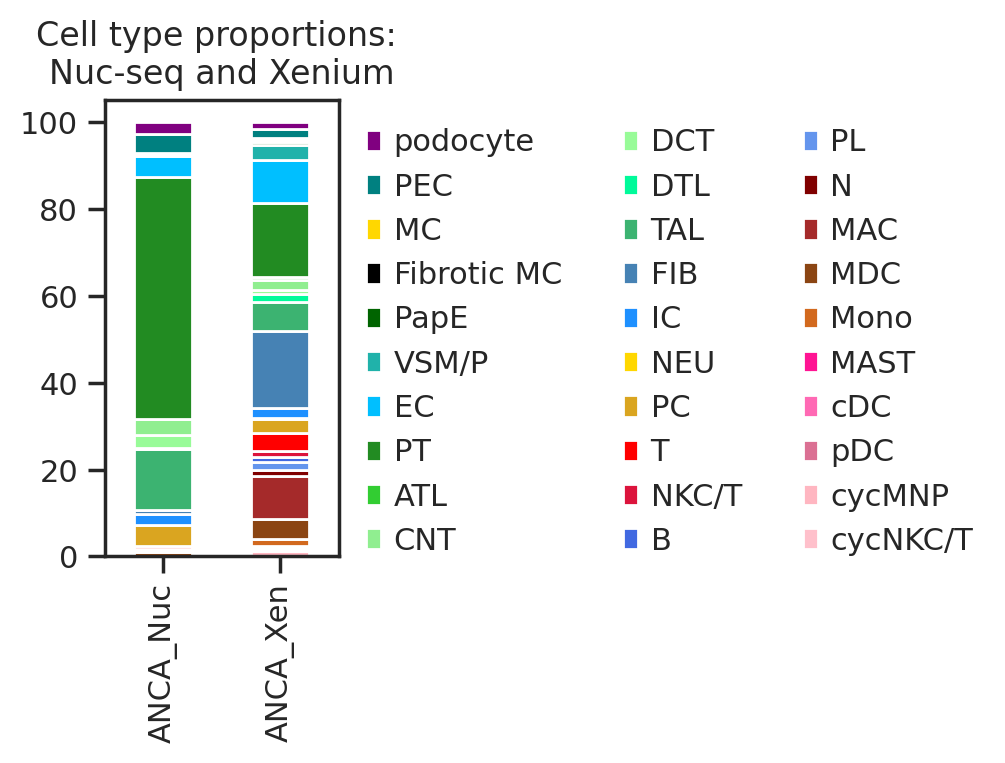

In [24]:
plot_stacked_bar(table=Xen_Nuc_ANCA,table_name='Cell type proportions: \nNuc-seq and Xenium',color_dict=custom_cmap_ck,figsize=(1.5, 3))